# Predict Adverse Drug Reactions (ADRs) with the LINCS L1000 data

---


## _Zichen Wang, Avi Ma'ayan_

<img src="http://lincs-dcic.org/images/dcic-logo/DCIC_500x375_cropped.png" style="float: right; width: 100px;"/>

#### BD2K-LINCS Data Coordination and Integration Center

#### CMap Workshop - Dec. 4th, 2018 

---

## Table of contents

- [0. Introductions](#0.-Introductions)
- [1. Prepare datasets for the Machine Learning task](#1.-Prepare-datasets-for-machine-learning)
- [2. Train and validate multi-label classification model to predict ADRs](#2.-Train-and-validate-multi-label-classification-models-to-predict-ADRs)
- [3. Other use cases](#3.-Other-use-cases-of-this-workflow)

---

# 0. Introductions

## Introduction to multi-label classification

- **Multi-label classification**: a variant of the classification problem where multiple target labels must be assigned to each instance. The goal is to find a model that maps input feature vector $\mathbf{x}$ to a binary vector $\mathbf{y}$ rather than a scalar output as in ordinary (single-label) classification problem.

<img src="img/multi-label_classification.png" style="width: 600px;"/>


- Approaches for Multi-label classification

    + **Problem transformation**: converts a multi-label problem to many single-label classification problems
        - **Binary Relevance (BR)**: train classifiers for each label individually and ignore label correlations
        - **Classifier Chain (CC)**: treats each label as a part of a conditioned chain of single-class classification problems
        - **Label Power-set (LP)**: treats each label combination as a separate class with one multi-class classification problem
    + **Algorithm adaptation**: change the cost functions of single-label classification algorithms to have multi-label objectives
        - K-Nearest Neighbors

- Evaluation metrics for Multi-label classification
    + **Label-based**: ROC curves for individual labels
    + **Instance-based**: Hamming loss, micro-averaged F1 score
    

## Apply of multi-label classification to predict drug side effects/ADRs

![](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4965635/bin/btw168f1p.jpg)

Wang Z, Clark NR, Ma'ayan A (2016) _Bioinformatics_ [doi: 10.1093/bioinformatics/btw168](https://www.ncbi.nlm.nih.gov/pubmed/27153606)

---

In [5]:
# Set paths to find the data required
## paths on jupyter.clue.io
# DATA_DIR = '/srv/data/workshop/data/common'
# DATA_MODULE3_DIR = '/srv/data/workshop/data/Module3'

## paths on my desktop
DATA_DIR = '/Volumes/Untitled/Zichen_Projects/LINCS_L1000_GSE92742_data/data/'
DATA_MODULE3_DIR = '/Volumes/Untitled/Zichen_Projects/LINCS_L1000_GSE92742_data/data/'

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from __future__ import print_function, division
import os, sys
import warnings
warnings.filterwarnings("ignore")
import h5py
import numpy as np
import pandas as pd
from sklearn import decomposition, manifold

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context='talk', style='white')

In [10]:
import plots
import gctx_utils

---
# 1. Prepare datasets for machine learning 

## 1.1. Prepare level 5 signatures for drugs/compounds

- load metadata for genes and signatures

In [11]:
gctx5 = h5py.File('%s/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx' % DATA_DIR, 'r')

In [12]:
gene_info_df = pd.read_csv('%s/GSE92742_Broad_LINCS_gene_info.txt' % DATA_DIR, 
                          sep='\t')
gene_info_df.set_index(gene_info_df.columns[0], inplace=True)
gene_info_df.index = gene_info_df.index.astype(str)
print(gene_info_df.shape)
# Get the Landmark 1000 genes
LM_GENE_IDS = gene_info_df.query('pr_is_lm == 1').index
LM_GENE_IDS = LM_GENE_IDS.values.astype(np.str) # convert to np.array with np.str as dtype
print('Number of landmark genes', len(LM_GENE_IDS))

(12328, 4)
Number of landmark genes 978


In [13]:
sig_info_df = pd.read_csv('%s/GSE92742_Broad_LINCS_sig_info.txt' % DATA_DIR, 
                          sep='\t')
sig_info_df = sig_info_df.set_index('sig_id')
print(sig_info_df.shape)

# Get compound treatment signatures in PC3 cell line
sig_info_df = sig_info_df.query('cell_id == "PC3" & pert_type == "trt_cp"')
print(sig_info_df.shape)

(473647, 11)
(23123, 11)


In [14]:
sig_info_df.nunique()

pert_id           11150
pert_iname        10661
pert_type             1
cell_id               1
pert_dose          1392
pert_dose_unit        1
pert_idose           27
pert_time             2
pert_time_unit        1
pert_itime            2
distil_id         23123
dtype: int64

## 1.2. Load chemical fingerprints for drugs/compounds

The 166-bit MACCS chemical fingerprints for drugs/compounds are generated using [Open Babel](http://openbabel.org/wiki/Main_Page). Each MACCS key corresponds to a chemical substructure/fragment.

In [15]:
drugs_fp_df = pd.read_csv('%s/MACCS_bitmatrix.csv.gz' % DATA_MODULE3_DIR, 
                         compression='gzip',
                         ).set_index('pert_id')
drugs_fp_df.shape

(41774, 166)

In [16]:
drugs_fp_df.head()

,MACCS_1,MACCS_2,MACCS_3,MACCS_4,MACCS_5,MACCS_6,MACCS_7,MACCS_8,MACCS_9,MACCS_10,...,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,MACCS_166
pert_id,,,,,,,,,,,,,,,,,,,,,
BRD-A00037023,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
BRD-A00051892,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,1,1,0,1,1
BRD-A00100033,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,1,1
BRD-A00150179,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,1,1,1,1,1
BRD-A00214921,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


## 1.3. Load drug-ADR connections from [SIDER](http://sideeffects.embl.de/)

SIDER contains information on marketed medicines and their recorded adverse drug reactions. The information is extracted from public documents and package inserts.

In [17]:
sider_df = pd.read_csv('%s/SIDER_PTs.csv.gz' % DATA_MODULE3_DIR, 
                      compression='gzip'
                      ).set_index('pert_id')
sider_df.shape

(834, 3165)

In [18]:
sider_df.head()

,Vulvovaginal disorder,Cardiac failure,Thalassaemia,Peritoneal haemorrhage,Cardiac murmur,Judgement impaired,Jaundice,Plasmodium falciparum infection,Influenza like illness,Ingrown hair,...,Phobia,Rash maculo-papular,Oesophageal candidiasis,Blepharitis,Muscle contractions involuntary,Echolalia,Dysplasia,Hypermagnesaemia,Ileus,Blood bilirubin increased
pert_id,,,,,,,,,,,,,,,,,,,,,
BRD-A00546892,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BRD-A00827783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BRD-A01320529,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BRD-A01636364,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BRD-A01643550,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 1.4. Find drugs/compounds that are shared among the three datasets

In [19]:
!pip install --user matplotlib-venn

In [20]:
from matplotlib_venn import venn3, venn2

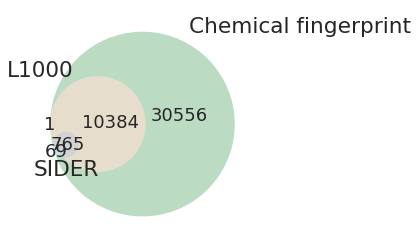

In [21]:
venn3([set(sig_info_df.pert_id), set(drugs_fp_df.index), set(sider_df.index)],
      ('L1000', 'Chemical fingerprint', 'SIDER')
     );

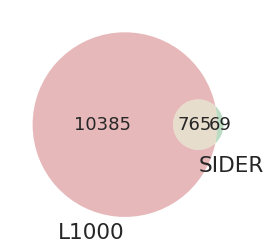

In [22]:
venn2([set(sig_info_df.pert_id), set(sider_df.index)],
      ('L1000', 'SIDER')
     );

In [27]:
shared_drugs = set(sig_info_df.pert_id) & set(drugs_fp_df.index) & set(sider_df.index)
shared_drugs = sorted(shared_drugs)
print(len(shared_drugs))

765


In [28]:
# Subset metadata with the shared drugs
sig_info_df = sig_info_df.loc[sig_info_df['pert_id'].isin(shared_drugs)]
sig_info_df.shape

(2723, 11)

In [29]:
# Retrieve L1000 signatures from the level 5 data
X_L1000 = gctx_utils.slice_matrix(gctx5, rids=LM_GENE_IDS, 
                                  cids=sig_info_df.index.values.astype(np.str))
X_L1000.shape

(2723, 978)

In [31]:
# Use PCA to reduce the dimensions of the gene expression signatures
pca = decomposition.PCA(n_components=50)
X_L1000_pca = pca.fit_transform(X_L1000)
X_L1000_pca.shape

(2723, 50)

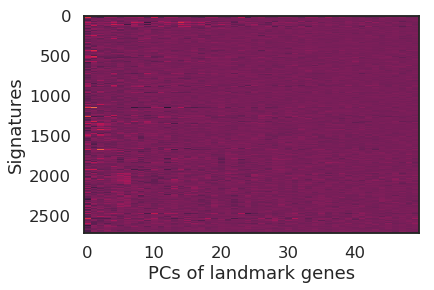

In [32]:
plt.imshow(X_L1000_pca, aspect='auto')
plt.ylabel('Signatures')
plt.xlabel('PCs of landmark genes');

In [35]:
# Subset chemical fingerprint matrix
X_CS = drugs_fp_df.loc[sig_info_df['pert_id']].values
# remove zero features
X_CS = X_CS[:, X_CS.sum(axis=0) > 0]
X_CS.shape

(2723, 154)

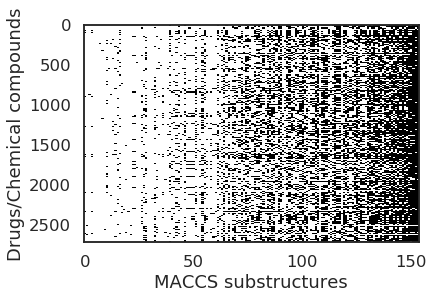

In [36]:
plt.imshow(X_CS, aspect='auto', cmap='binary');
plt.ylabel('Drugs/Chemical compounds')
plt.xlabel('MACCS substructures');

In [37]:
pca = decomposition.TruncatedSVD(n_components=50)
X_CS_pca = pca.fit_transform(X_CS)

In [38]:
# Subset SIDER matrix
Y = sider_df.loc[sig_info_df['pert_id']].values
Y.shape

(2723, 3165)

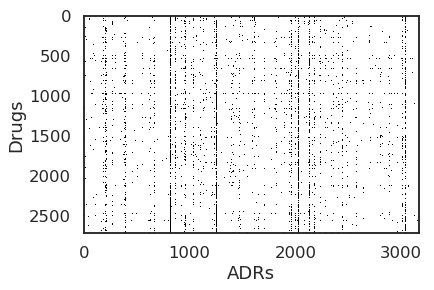

In [39]:
plt.imshow(Y, aspect='auto', cmap='binary')
plt.ylabel('Drugs')
plt.xlabel('ADRs');

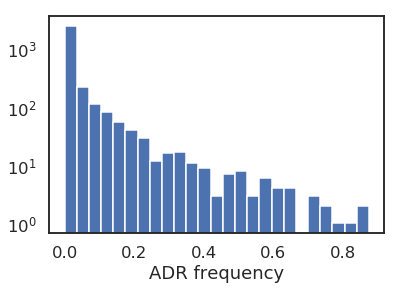

In [40]:
# Examine label (ADR) frequencies
freqs_ADR = Y.mean(axis=0)
plt.hist(freqs_ADR, bins=25, log=True)
plt.xlabel('ADR frequency');

In [41]:
# Examine frequent ADRs
ADRs_freq_df = pd.DataFrame({'frequency': freqs_ADR}, 
                            index=sider_df.columns)

ADRs_freq_df.sort_values('frequency', ascending=False).head(10)

,frequency
Nausea,0.874770
Rash,0.854939
Vomiting,0.827029
Headache,0.791039
Pain,0.762027
Diarrhoea,0.742196
Oedema,0.723467
Dizziness,0.719427
Pruritus,0.710981
Hypersensitivity,0.651855


In [42]:
# Examine infrequent ADRs
ADRs_freq_df.query('frequency > 0').sort_values('frequency').head(10)

,frequency
Brain abscess,0.000367
Hepatoblastoma,0.000367
Serum sickness-like reaction,0.000367
Ear pruritus,0.000367
Ovarian neoplasm,0.000367
Haemorrhagic anaemia,0.000367
Renal cell carcinoma,0.000367
Tooth deposit,0.000367
Ovarian germ cell teratoma benign,0.000367
Hypercoagulation,0.000367


In [43]:
# Exclude ADRs that are too infrequent or frequent
mask_ADR_to_predict = (freqs_ADR > 0.2) & (freqs_ADR < 0.7)

Y = Y[:, mask_ADR_to_predict]
Y.shape

(2723, 143)

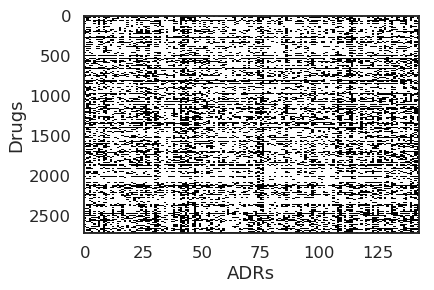

In [44]:
plt.imshow(Y, aspect='auto', cmap='binary');
plt.ylabel('Drugs')
plt.xlabel('ADRs');

---
# 2. Train and validate multi-label classification models to predict ADRs

In [47]:
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain
from skmultilearn.ensemble import RakelD
from sklearn import linear_model, ensemble, metrics
from sklearn.model_selection import GroupKFold

In [48]:
def cross_validate_ml_clf(ml_clf, cv, X, Y, groups):
    '''
    Perform cross validation for a ml-classifier on data and return evaluation metrics.
    @params:
        ml_clf: multi-label classifier
        cv: a cross-validation object
        X: data matrix (instances x features)
        Y: target matrix (instances x labels)
        groups: the same group (signatures of the same compound) will not appear 
            in two different folds to avoid over-estimation of predictive performance.
    '''
    i = 0 
    scores_df = pd.DataFrame(columns=['hamming_loss', 'accuracy', 'F1'])
    label_aurocs = np.zeros(Y.shape[1])
    
    for train_idx, valid_idx in cv.split(X, Y, groups):
        X_train, X_valid = X[train_idx], X[valid_idx]
        Y_train, Y_valid = Y[train_idx], Y[valid_idx]
        print(X_train.shape, Y_train.shape)
        print(X_valid.shape, Y_valid.shape)
        ml_clf.fit(X_train, Y_train)

        Y_valid_pred = ml_clf.predict(X_valid)
        if type(Y_valid_pred) != np.ndarray:
            Y_valid_pred = Y_valid_pred.toarray() # convert sparse matrix to dense
        
        hamming_loss = metrics.hamming_loss(Y_valid, Y_valid_pred)
        acc = metrics.accuracy_score(Y_valid.ravel(), Y_valid_pred.ravel())
        f1 = metrics.f1_score(Y_valid, Y_valid_pred, average='micro') # micro-F1
        print('Fold %d, hamming loss=%.4f, accuracy=%.4f, F1=%.4f'% (i, hamming_loss, acc, f1))
        scores_df.loc[i] = [hamming_loss, acc, f1]

        Y_valid_pred_probas = ml_clf.predict_proba(X_valid)
        if type(Y_valid_pred_probas) != np.ndarray:
            Y_valid_pred_probas = Y_valid_pred_probas.toarray() # convert sparse matrix to dense
        
        # Per-label AUROC scores        
        aurocs = metrics.roc_auc_score(Y_valid, Y_valid_pred_probas, average=None)
        label_aurocs += aurocs / cv.n_splits
        i += 1
    return scores_df, label_aurocs

In [49]:
# Set up cross-validation iterator
cv = GroupKFold(n_splits=3)

## 2.1. Examine the performances of a few multi-label classification algorithms

A simple single-label Random Forest classifier is used as the base classifier for the following multi-label algorithms:

- Binary Relevance (BR)
- Classifier Chain (CC)
- Distinct RAndom k-labELsets multi-label classifier (RAkELd)

In [55]:
rf = ensemble.RandomForestClassifier(n_estimators=10, n_jobs=5)
br_rf = BinaryRelevance(
    classifier=rf
)

In [56]:
scores_df, label_aurocs = cross_validate_ml_clf(br_rf, cv, X_L1000_pca, Y, 
                                                groups=sig_info_df.pert_id)

(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 0, hamming loss=0.3450, accuracy=0.6550, F1=0.3393
(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 1, hamming loss=0.3325, accuracy=0.6675, F1=0.3552
(1816, 50) (1816, 143)
(907, 50) (907, 143)
Fold 2, hamming loss=0.3542, accuracy=0.6458, F1=0.3530


In [57]:
cc_rf = ClassifierChain(
    classifier=rf
)

In [58]:
scores_df2, label_aurocs2 = cross_validate_ml_clf(cc_rf, cv, X_L1000_pca, Y,
                                                 groups=sig_info_df.pert_id)

(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 0, hamming loss=0.3468, accuracy=0.6532, F1=0.1036
(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 1, hamming loss=0.3234, accuracy=0.6766, F1=0.1106
(1816, 50) (1816, 143)
(907, 50) (907, 143)
Fold 2, hamming loss=0.3635, accuracy=0.6365, F1=0.0986


In [59]:
rakeld = RakelD(base_classifier=rf,
               base_classifier_require_dense=[True, True],
               labelset_size=3)

In [60]:
scores_df3, label_aurocs3 = cross_validate_ml_clf(rakeld, cv, X_L1000_pca, Y,
                                                 groups=sig_info_df.pert_id)

(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 0, hamming loss=0.3557, accuracy=0.6443, F1=0.3342
(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 1, hamming loss=0.3412, accuracy=0.6588, F1=0.3560
(1816, 50) (1816, 143)
(907, 50) (907, 143)
Fold 2, hamming loss=0.3584, accuracy=0.6416, F1=0.3566


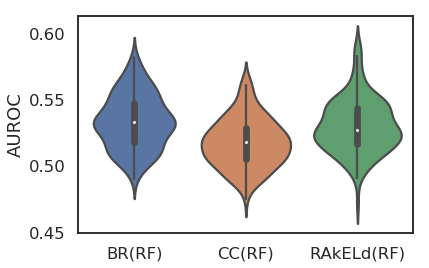

In [61]:
ax = sns.violinplot(data=pd.DataFrame({'BR(RF)': label_aurocs, 
                                  'CC(RF)': label_aurocs2,
                                  'RAkELd(RF)': label_aurocs3,                                       
                                 }))
ax.set_ylabel('AUROC');

## 2.2. Cross-validate classifier on different subset of features 

The following features are used for multi-label prediction of ADRs:
- L1000 signatures alone
- chemical fingerprints alone
- combining L1000 + chemical fingerprints

In [62]:
scores_df_GE, aurocs_GE = cross_validate_ml_clf(br_rf, cv, X_L1000_pca, Y, 
                                                groups=sig_info_df.pert_id)

(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 0, hamming loss=0.3435, accuracy=0.6565, F1=0.3402
(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 1, hamming loss=0.3343, accuracy=0.6657, F1=0.3510
(1816, 50) (1816, 143)
(907, 50) (907, 143)
Fold 2, hamming loss=0.3558, accuracy=0.6442, F1=0.3483


In [63]:
scores_df_CS, aurocs_CS = cross_validate_ml_clf(br_rf, cv, X_CS_pca, Y, 
                                                groups=sig_info_df.pert_id)

(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 0, hamming loss=0.3093, accuracy=0.6907, F1=0.4071
(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 1, hamming loss=0.2663, accuracy=0.7337, F1=0.4810
(1816, 50) (1816, 143)
(907, 50) (907, 143)
Fold 2, hamming loss=0.2724, accuracy=0.7276, F1=0.5280


In [64]:
scores_df_GECS, aurocs_GECS = cross_validate_ml_clf(br_rf, cv, np.hstack((X_L1000_pca, X_CS_pca)), Y,
                                                   groups=sig_info_df.pert_id)

(1815, 100) (1815, 143)
(908, 100) (908, 143)
Fold 0, hamming loss=0.3068, accuracy=0.6932, F1=0.4105
(1815, 100) (1815, 143)
(908, 100) (908, 143)
Fold 1, hamming loss=0.2710, accuracy=0.7290, F1=0.4679
(1816, 100) (1816, 143)
(907, 100) (907, 143)
Fold 2, hamming loss=0.2812, accuracy=0.7188, F1=0.5035


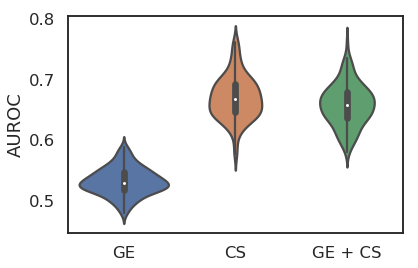

In [65]:
ax = sns.violinplot(data=pd.DataFrame({'GE': aurocs_GE, 
                                  'CS': aurocs_CS,
                                  'GE + CS': aurocs_GECS,
                                 }))
ax.set_ylabel('AUROC');

In [66]:
auroc_df = pd.DataFrame({'auroc': aurocs_GECS}, index=sider_df.columns[mask_ADR_to_predict])
# Most predictable ADRs
auroc_df.sort_values('auroc', ascending=False).head()

,auroc
Agranulocytosis,0.760414
Dermatitis exfoliative,0.734873
Vasculitis,0.730803
Pancytopenia,0.730749
Pneumonia,0.724530


In [67]:
# Least predictable ADRs
auroc_df.sort_values('auroc').head()

,auroc
Discomfort,0.580940
Ear pain,0.589107
Migraine,0.590346
Dry skin,0.595321
Acne,0.596141


---
# 3. Other use cases of this workflow

- Predicting attributes of drugs:
    + Indications
    + Targets
    + MOAs
- Predicting attributes of genes using the L1000 KD/OE/CRISPR gene signatures
    + Pathways
    + Functions
    + KO Mouse phenotypes 